# Raw versus Normalized Spectra Experiment

In [1]:
import tensorflow
import pandas
import numpy
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline

In [3]:
tensorflow.__version__

'1.8.0'

In [4]:
WAVES = numpy.linspace(6519, 6732, num=140)

## Load the Data

In [5]:
raw_df = pandas.read_csv('data/raw-dataset.csv', index_col='id')
raw_df.sort_index(inplace=True)
norm_df = pandas.read_csv('data/normalized-dataset.csv', index_col='id')
norm_df.sort_index(inplace=True)
raw_df.head()

,dec,gratang,detector,expval,object,dichmir,chipid,ra,specfilt,label,...,6718.20863309,6719.74100719,6721.27338129,6722.8057554,6724.3381295,6725.8705036,6727.4028777,6728.9352518,6730.4676259,6732.0
id,,,,,,,,,,,,,,,,,,,,,
a201305230017,-11:09:40.70,30.25,PyLoN 2048x512BX,19.246130,alp Vir,2,E2V 42-10 BX,13:25:11.580,1,absorption,...,506096.210748,505286.047228,504106.925201,502043.387652,499827.958541,498385.165956,498190.044968,499302.148265,500607.698358,500899.192757
a201306060015,+19:10:56.60,30.25,PyLoN 2048x512BX,0.009187,alp Boo,2,E2V 42-10 BX,14:15:39.667,1,absorption,...,193644.604516,194951.353066,200427.247481,203353.778155,203940.311357,203613.661065,202053.255088,202003.060090,203675.565714,204506.290588
a201306060016,+19:10:56.60,30.25,PyLoN 2048x512BX,0.012332,alp Boo,2,E2V 42-10 BX,14:15:39.667,1,absorption,...,307559.413555,309575.702337,318283.859189,323097.056161,324141.074458,323543.630765,320970.267304,320887.844222,323502.907113,324655.685273
a201306060018,+33:21:45.60,30.25,PyLoN 2048x512BX,5.056532,beta Lyr,2,E2V 42-10 BX,18:50:04.787,1,emission,...,44950.487947,45019.574545,44910.009841,44719.100229,44689.037403,44724.791337,44700.993767,44705.082297,44752.548428,44734.531766
a201306060019,+33:21:45.60,30.25,PyLoN 2048x512BX,15.040130,beta Lyr,2,E2V 42-10 BX,18:50:04.787,1,emission,...,125795.778619,126004.868747,125788.287910,125227.841525,125145.712758,125330.650720,125332.395056,125338.057872,125376.976633,125252.358114


## Dataset Split

In [6]:
# according to objects
objects = raw_df['object'].unique()
tr_objects, te_objects = train_test_split(objects, test_size=0.2)
tr_objects, val_objects = train_test_split(tr_objects, test_size=0.3)

tr_idx = raw_df['object'].isin(tr_objects)
val_idx = raw_df['object'].isin(val_objects)
te_idx = raw_df['object'].isin(te_objects)

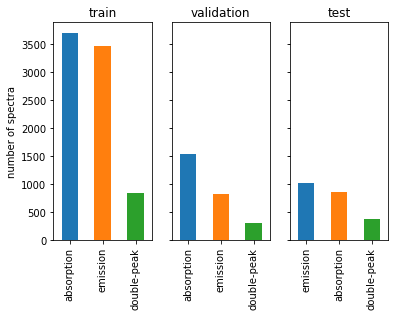

In [7]:
def preview_splits():
    _, axes = pyplot.subplots(ncols=3, sharey=True)
    for ax, idx, title in zip(axes, (tr_idx, val_idx, te_idx), ('train', 'validation', 'test')):
        raw_df.loc[idx, 'label'].value_counts().plot.bar(ax=ax)
        ax.set_ylabel('number of spectra')
        ax.set_title(title)

preview_splits()

## Encode Labels

In [8]:
le = preprocessing.LabelEncoder()
le.fit(raw_df['label'])
print(le.classes_)
#le.inverse_transform(encoded)

enc = preprocessing.OneHotEncoder(sparse=False)
raw_y = enc.fit_transform(le.transform(raw_df['label']).reshape(-1, 1))
norm_y = enc.fit_transform(le.transform(norm_df['label']).reshape(-1, 1))
raw_y, raw_y.shape

['absorption' 'double-peak' 'emission']


(array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.]]), (12936, 3))

## Scaling

In [9]:
norm_X = norm_df.iloc[:, 1:].as_matrix()
raw_X = raw_df.iloc[:, 11:].as_matrix()
raw_X.shape, norm_X.shape, raw_X.var(axis=1), raw_X.mean(axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


((12936, 140),
 (12936, 140),
 array([8.92238819e+08, 6.44109290e+07, 1.65213469e+08, ...,
        2.65454673e+07, 1.87183296e+07, 1.77052099e+06]),
 array([528856.20335521, 206017.43843591, 328129.03953654, ...,
        123712.81054967,  35333.47062053,  10215.4039011 ]))

In [10]:
raw_X_scaled = preprocessing.scale(raw_X, axis=1)
norm_X_scaled = preprocessing.scale(norm_X, axis=1)
raw_X_scaled.var(axis=1), raw_X_scaled.mean(axis=1)

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([-8.01660325e-15,  5.17007072e-15, -1.32386166e-14, ...,
        -3.91115711e-15,  2.67246542e-16,  3.31480874e-15]))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


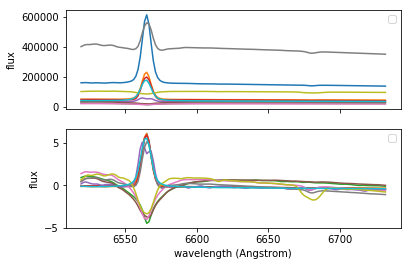

In [11]:
def preview_scaling(size):
    idxs = numpy.random.choice(raw_X.shape[0], size=size, replace=False)
    _, (ax1, ax2) = pyplot.subplots(nrows=2, sharex=True)
    ax2.set_xlabel('wavelength (Angstrom)')
    ax1.set_ylabel('flux')
    ax2.set_ylabel('flux')
    for idx in idxs:
        ax1.plot(WAVES, raw_X[idx])
        ax2.plot(WAVES, raw_X_scaled[idx])
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')

preview_scaling(10)

## Neural Network

In [12]:
# variables are inialized with small amount of nosise for symmetry breaking
# and to prevent 0 gradients
# since using ReLU neurons it's good to initialize with positive bias to
# avoid 'dead neurons'
def weight_variable(shape):
    # values whose magnitude is more than 2 standard deviations
    # from the mean are dropped and re-picked
    initial = tensorflow.truncated_normal(shape, stddev=0.1)
    return tensorflow.Variable(initial)

def bias_variable(shape):
    initial = tensorflow.constant(0.1, shape=shape)
    return tensorflow.Variable(initial)

def conv2d(x, W):
    return tensorflow.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_1x2(x):
    return tensorflow.nn.max_pool(x, ksize=[1, 1, 2, 1],
                                  strides=[1, 1, 2, 1], padding='VALID')

# computes 32 features for each 1x3 patch
# the first two dimensions are the patch siez
# next is the number of input channels
N_CHANNELS = 32
W_conv1 = weight_variable([1, 3, 1, N_CHANNELS])
# bias for each output channel
b_conv1 = bias_variable([N_CHANNELS])

# TODO consider float64
x = tensorflow.placeholder(tensorflow.float32, shape=[None, 140])
# 2d tensor of one-hot 3-dimensional vector
y_ = tensorflow.placeholder(tensorflow.float32, shape=[None, 3])

x_spectra = tensorflow.reshape(x, [-1, 1, 140, 1])

h_conv1 = tensorflow.nn.relu(conv2d(x_spectra, W_conv1) + b_conv1)
h_pool1 = max_pool_1x2(h_conv1)

# dense layer
N_DENSE = 512
W_fc1 = weight_variable([69 * N_CHANNELS, N_DENSE])
b_fc1 = bias_variable([N_DENSE])
h_pool1_flat = tensorflow.reshape(h_pool1, [-1, 69 * N_CHANNELS])
h_fc1 = tensorflow.nn.relu(tensorflow.matmul(h_pool1_flat, W_fc1) + b_fc1)

# dropout
keep_prob = tensorflow.placeholder(tensorflow.float32)
h_fc1_drop = tensorflow.nn.dropout(h_fc1, keep_prob)

# readout layer
W_fc2 = weight_variable([N_DENSE, 3])
b_fc2 = bias_variable([3])
y_conv = tensorflow.matmul(h_fc1_drop, W_fc2) + b_fc2

cross_entropy = tensorflow.reduce_mean(tensorflow.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tensorflow.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tensorflow.equal(tensorflow.argmax(y_conv, 1), tensorflow.argmax(y_, 1))
accuracy = tensorflow.reduce_mean(tensorflow.cast(correct_prediction, tensorflow.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Traing and Evalutation

In [13]:
def train(X_tr, y_tr, X_val, y_val, epochs, batch_size):
    with tensorflow.Session() as sess:
        sess.run(tensorflow.global_variables_initializer())

        for epoch in range(epochs):
            # shuffle the data for each epoch to get random batches
            X, y = utils.shuffle(X_tr, y_tr)

            for k in range(0, len(X), batch_size):
                batch_X = X[k:k + batch_size]
                batch_y = y[k:k + batch_size]
                train_step.run(feed_dict={x: batch_X, y_: batch_y, keep_prob: 0.5})

            train_accuracy = accuracy.eval(feed_dict={x: X, y_: y, keep_prob: 1.0})
            print('epoch {} training accuracy {}'.format(epoch, train_accuracy))

        validation_accuracy = accuracy.eval(feed_dict={x: X_val, y_: y_val, keep_prob: 1.0})
        print('validation accuracy {}'.format(validation_accuracy))

train(raw_X_scaled[tr_idx | val_idx], raw_y[tr_idx | val_idx],
      raw_X_scaled[te_idx], raw_y[te_idx],
      epochs=100, batch_size=128)

epoch 0 training accuracy 0.9047752618789673
epoch 1 training accuracy 0.9350187182426453
epoch 2 training accuracy 0.9382959008216858
epoch 3 training accuracy 0.9463483095169067
epoch 4 training accuracy 0.9509363174438477
epoch 5 training accuracy 0.95168536901474
epoch 6 training accuracy 0.9539325833320618
epoch 7 training accuracy 0.9619849920272827
epoch 8 training accuracy 0.9639512896537781
epoch 9 training accuracy 0.9637640714645386
epoch 10 training accuracy 0.9658239483833313
epoch 11 training accuracy 0.9672284722328186
epoch 12 training accuracy 0.9670411944389343
epoch 13 training accuracy 0.9705055952072144
epoch 14 training accuracy 0.9676029682159424
epoch 15 training accuracy 0.967509388923645
epoch 16 training accuracy 0.967509388923645
epoch 17 training accuracy 0.9698501825332642
epoch 18 training accuracy 0.9695692658424377
epoch 19 training accuracy 0.9641385674476624
epoch 20 training accuracy 0.9724718928337097
epoch 21 training accuracy 0.9725655317306519
ep

In [14]:
train(norm_X_scaled[tr_idx | val_idx], norm_y[tr_idx | val_idx],
      norm_X_scaled[te_idx], norm_y[te_idx],
      epochs=100, batch_size=128)

epoch 0 training accuracy 0.9180711507797241
epoch 1 training accuracy 0.9392322301864624
epoch 2 training accuracy 0.9546816349029541
epoch 3 training accuracy 0.9544943571090698
epoch 4 training accuracy 0.9537453055381775
epoch 5 training accuracy 0.9615168571472168
epoch 6 training accuracy 0.956367015838623
epoch 7 training accuracy 0.9637640714645386
epoch 8 training accuracy 0.9667602777481079
epoch 9 training accuracy 0.9645131230354309
epoch 10 training accuracy 0.9647939801216125
epoch 11 training accuracy 0.9710674285888672
epoch 12 training accuracy 0.9712547063827515
epoch 13 training accuracy 0.9683520793914795
epoch 14 training accuracy 0.9716292023658752
epoch 15 training accuracy 0.9708801507949829
epoch 16 training accuracy 0.9730337262153625
epoch 17 training accuracy 0.9727528095245361
epoch 18 training accuracy 0.9717228412628174
epoch 19 training accuracy 0.9705055952072144
epoch 20 training accuracy 0.9747191071510315
epoch 21 training accuracy 0.9730337262153625